# 03 - Análisis del Ecosistema Tecnológico

**Objetivo:** Analizar el panorama tecnológico global y chileno, identificando tendencias, brechas de adopción y oportunidades para desarrolladores.

Este notebook complementa el análisis de modelos predictivos (notebook 02) con un enfoque en:
- **Tecnologías más utilizadas** (lenguajes, frameworks, herramientas)
- **Tendencias temporales** (2023 vs 2025)
- **Comparación Chile vs Global**
- **Análisis de salarios por tecnología**
- **Recomendaciones estratégicas**

**Dataset:** Stack Overflow Developer Survey 2023 + 2025 (68,613 registros procesados)

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('ggplot')
sns.set_palette('husl')

# Rutas
project_root = Path('..') if Path('..').joinpath('data').exists() else Path('.')
reporting_dir = project_root / 'data' / '08_reporting'
reporting_dir.mkdir(parents=True, exist_ok=True)

print('Librerías cargadas correctamente')

Librerías cargadas correctamente


## 1. Carga de Datos y Configuración Inicial

En esta sección cargaremos los datasets raw (datos originales sin procesar) de Stack Overflow Developer Survey para analizar:

- **Variables categóricas**: Lenguajes, frameworks, herramientas DevOps
- **Variables demográficas**: País, edad, nivel educativo
- **Variables de experiencia**: Años de código, tipo de desarrollador
- **Variables de compensación**: Salarios anuales

### Estrategia de Carga

1. **Intento 1**: Cargar desde catálogo de Kedro (si está disponible)
2. **Intento 2**: Carga directa desde archivos CSV
3. **Integración**: Combinar datos de 2023 y 2025 si ambos están disponibles

**Resultado esperado**: Dataset combinado con columna `Year` para análisis temporal.

In [97]:
# Ruta al dataset
ruta_2023 = project_root / 'data' / '01_raw' / 'stackoverflow_2023' / 'stack_overflow_survey_results_public.csv'
ruta_2025 = project_root / 'data' / '01_raw' / 'stackoverflow_2025' / 'survey_results_public.csv'

# Cargar datos
try:
    df_2023 = pd.read_csv(ruta_2023, encoding='utf-8-sig')
    print(f'Dataset 2023 cargado: {df_2023.shape[0]:,} filas, {df_2023.shape[1]} columnas')
except FileNotFoundError:
    print(f'Archivo no encontrado: {ruta_2023}')
    df_2023 = pd.DataFrame()

try:
    df_2025 = pd.read_csv(ruta_2025, encoding='utf-8-sig')
    print(f'Dataset 2025 cargado: {df_2025.shape[0]:,} filas, {df_2025.shape[1]} columnas')
except FileNotFoundError:
    print(f'Archivo 2025 no encontrado, usando solo 2023')
    df_2025 = pd.DataFrame()

# Combinar si ambos existen
if not df_2023.empty and not df_2025.empty:
    df_2023['Year'] = 2023
    df_2025['Year'] = 2025
    # Usar columnas comunes
    cols_comunes = list(set(df_2023.columns) & set(df_2025.columns))
    df = pd.concat([df_2023[cols_comunes], df_2025[cols_comunes]], ignore_index=True)
    print(f'\nDataset combinado: {len(df):,} registros totales')
else:
    df = df_2023.copy()
    print(f'\nUsando solo dataset 2023: {len(df):,} registros')

Dataset 2023 cargado: 89,184 filas, 84 columnas
Dataset 2025 cargado: 49,123 filas, 170 columnas

Dataset combinado: 138,307 registros totales


## 2. Exploración Inicial: Columnas Disponibles

Identifiquemos las columnas relacionadas con tecnologías, experiencia y demografía.

In [98]:
if not df_2023.empty:
    # Mostrar información básica del dataset
    df_2023.info()
    
    # Primeras filas del dataset
    df_2023.head()

    # Columnas de interés
    tech_cols = [col for col in df_2023.columns if 'Language' in col or 'Database' in col or
                 'Platform' in col or 'Framework' in col or 'Tool' in col or 'Cloud' in col]

    demo_cols = [col for col in df_2023.columns if 'Country' in col or 'Age' in col or
                 'Gender' in col or 'EdLevel' in col]

    exp_cols = [col for col in df_2023.columns if 'Years' in col or 'DevType' in col]

    comp_cols = [col for col in df_2023.columns if 'Comp' in col or 'Salary' in col]

    # Resumen de columnas por categoría
    columnas_resumen = pd.DataFrame({
        'Categoría': ['Tecnologías', 'Demografía', 'Experiencia', 'Compensación'],
        'Cantidad': [len(tech_cols), len(demo_cols), len(exp_cols), len(comp_cols)],
        'Ejemplos': [
            ', '.join(tech_cols[:3]) + ('...' if len(tech_cols) > 3 else ''),
            ', '.join(demo_cols[:3]) + ('...' if len(demo_cols) > 3 else ''),
            ', '.join(exp_cols[:3]) + ('...' if len(exp_cols) > 3 else ''),
            ', '.join(comp_cols[:3]) + ('...' if len(comp_cols) > 3 else '')
        ]
    })
    columnas_resumen



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89184 entries, 0 to 89183
Data columns (total 85 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ResponseId                           89184 non-null  int64  
 1   Q120                                 89184 non-null  object 
 2   MainBranch                           89184 non-null  object 
 3   Age                                  89184 non-null  object 
 4   Employment                           87898 non-null  object 
 5   RemoteWork                           73810 non-null  object 
 6   CodingActivities                     73764 non-null  object 
 7   EdLevel                              87973 non-null  object 
 8   LearnCode                            87663 non-null  object 
 9   LearnCodeOnline                      70084 non-null  object 
 10  LearnCodeCoursesCert                 37076 non-null  object 
 11  YearsCode                   

## 3. Análisis de Lenguajes de Programación

Los lenguajes de programación son fundamentales para entender el ecosistema tecnológico. En esta sección analizamos:

- **Popularidad global**: ¿Qué lenguajes son más utilizados?
- **Tendencias**: ¿Qué lenguajes están creciendo?
- **Comparación Chile vs Global**: ¿Hay diferencias en la adopción?

### 3.1 Top 20 Lenguajes Más Utilizados (Global)

Este análisis identifica los lenguajes de programación más populares a nivel global, basado en el número de desarrolladores que reportan usarlos.

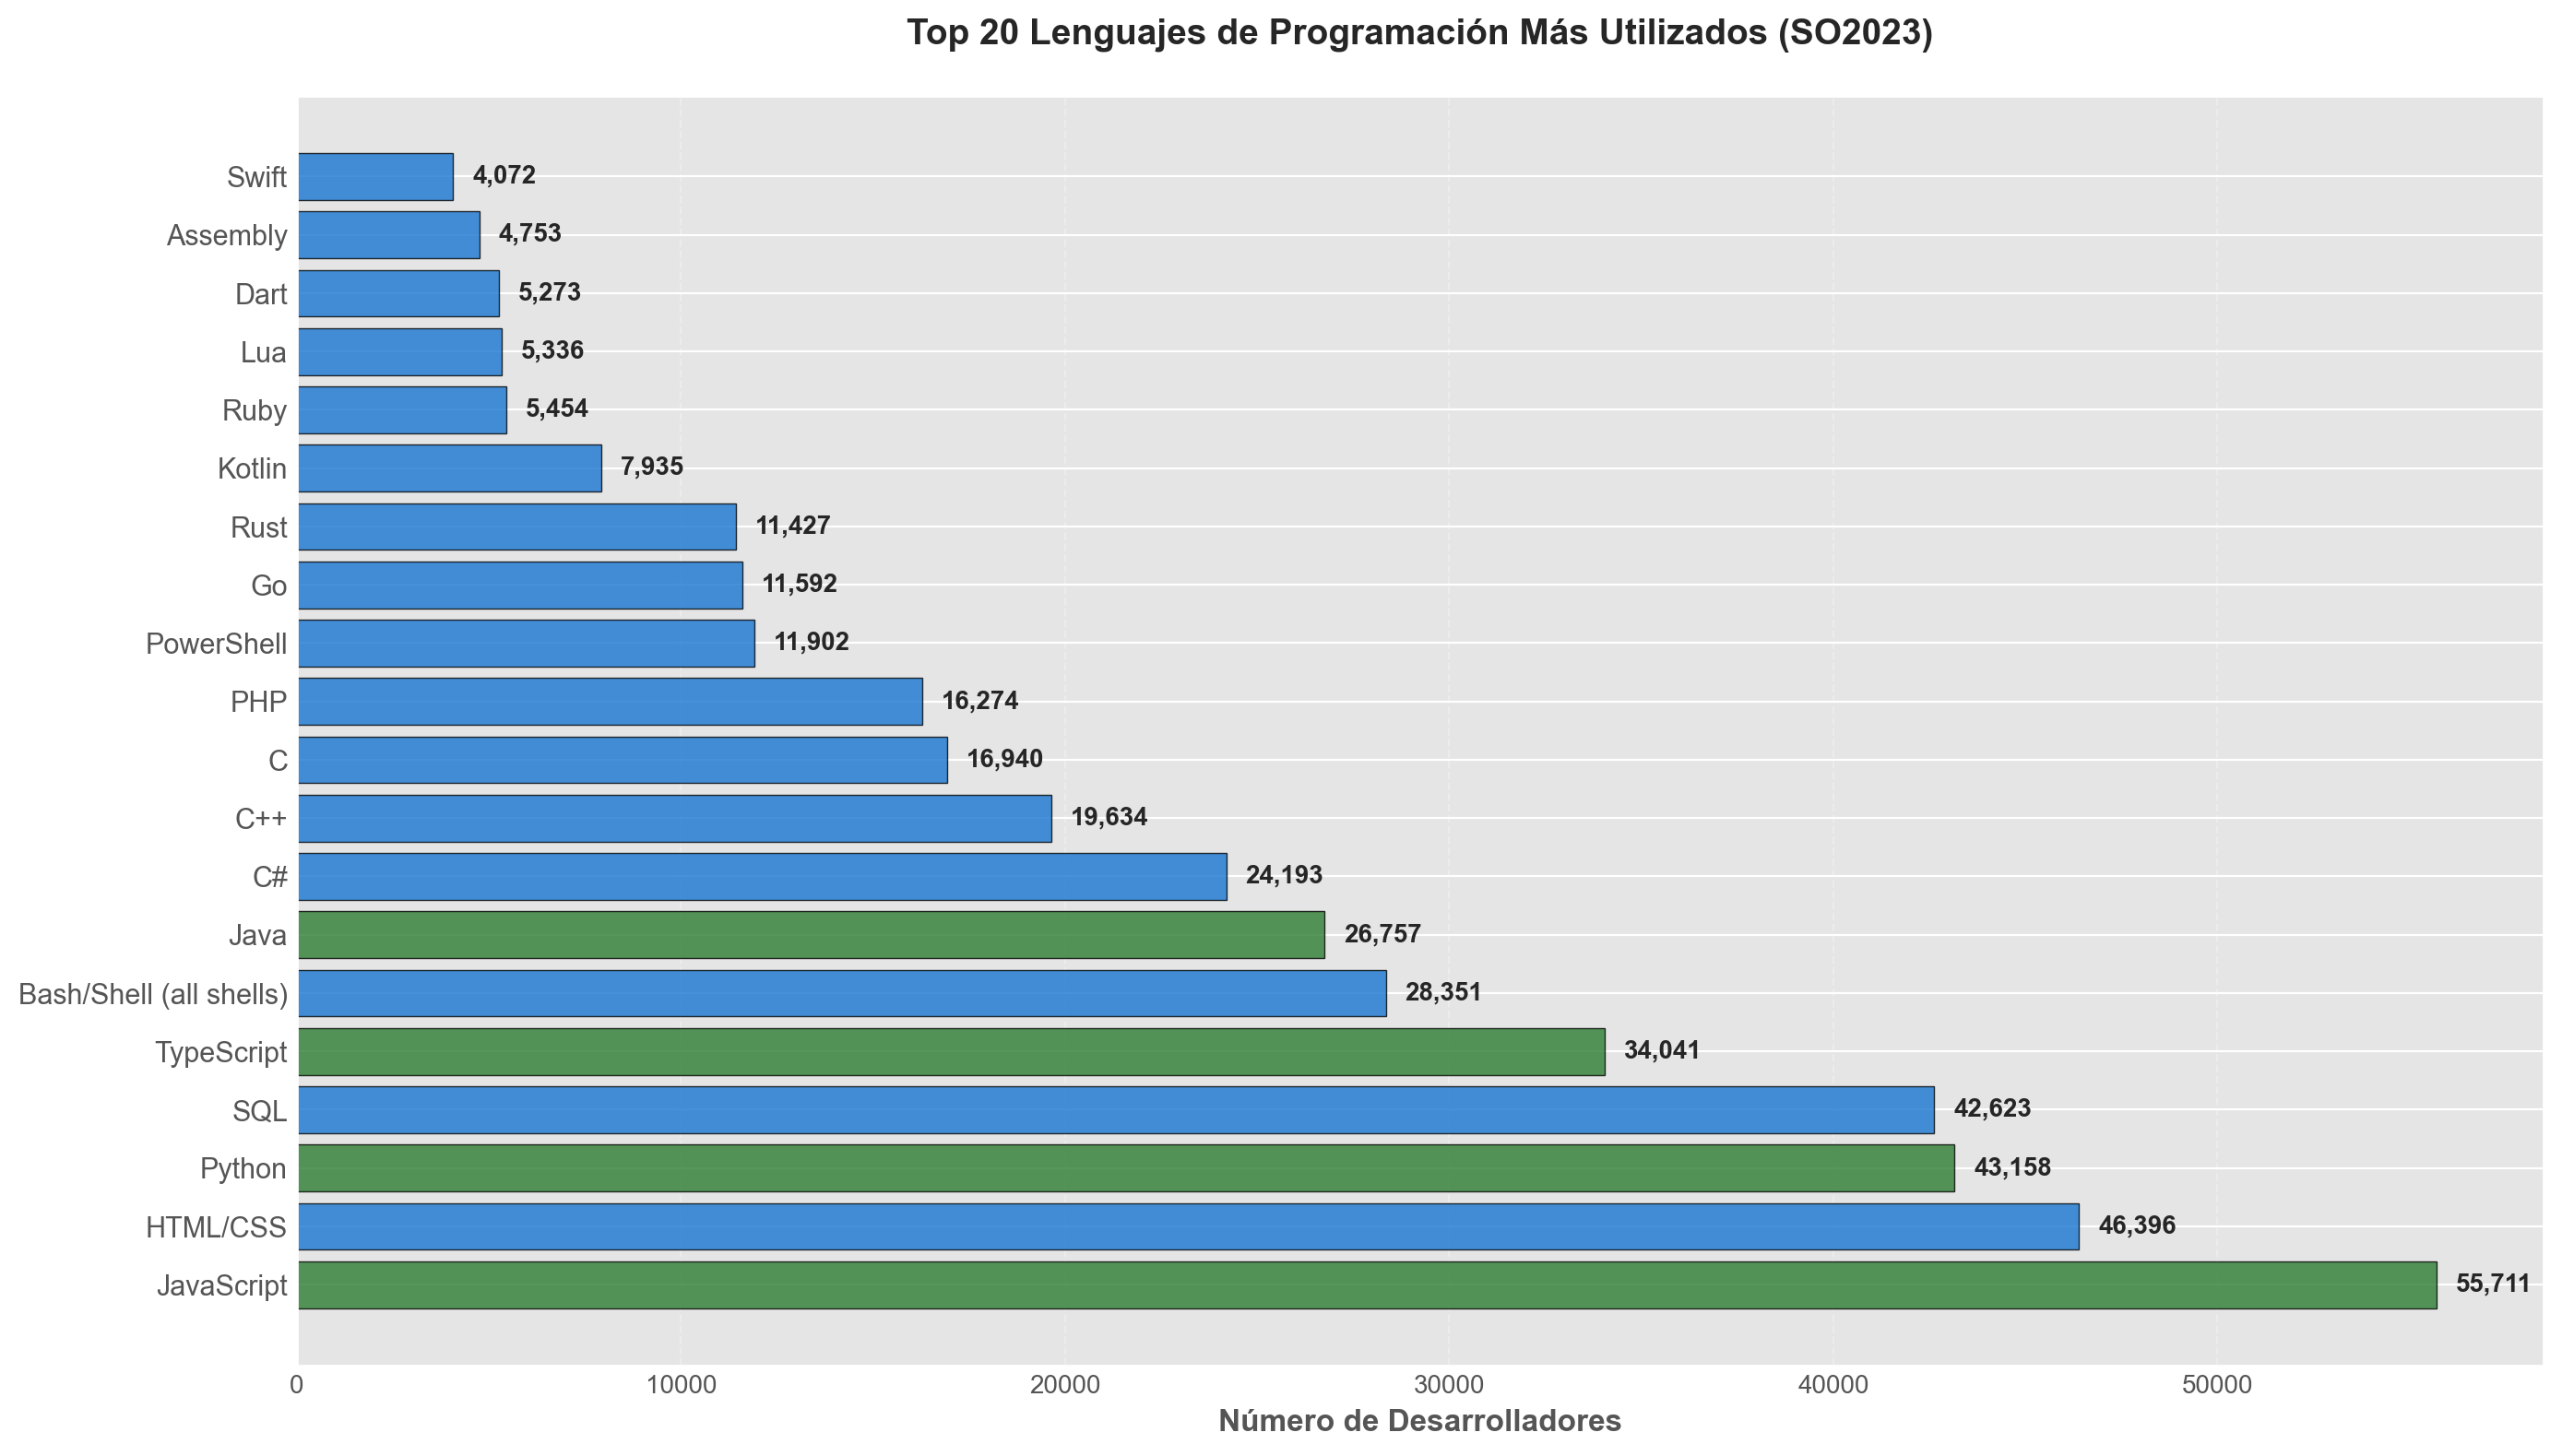

In [99]:
if not df_2023.empty and 'LanguageHaveWorkedWith' in df_2023.columns:
    # Procesar lenguajes (vienen separados por ';')
    languages_series = df_2023['LanguageHaveWorkedWith'].dropna().str.split(';').explode()
    language_counts = languages_series.value_counts()
    
    # Estadísticas básicas
    stats_df = pd.DataFrame({
        'Métrica': ['Total respuestas válidas', 'Lenguajes únicos', 'Lenguaje más popular', 'Usuarios del #1'],
        'Valor': [
            f"{len(df_2023['LanguageHaveWorkedWith'].dropna()):,}",
            f"{len(language_counts)}",
            language_counts.index[0] if len(language_counts) > 0 else 'N/A',
            f"{language_counts.iloc[0]:,}" if len(language_counts) > 0 else 'N/A'
        ]
    })
    stats_df

    # Top 20 lenguajes como DataFrame
    top_20_languages = language_counts.head(20)
    top_20_df = pd.DataFrame({
        'Lenguaje': top_20_languages.index,
        'Desarrolladores': top_20_languages.values,
        'Porcentaje (%)': (top_20_languages.values / len(df_2023) * 100).round(2)
    })
    top_20_df.index = range(1, len(top_20_df) + 1)
    top_20_df

    # Visualización
    fig, ax = plt.subplots(figsize=(14, 8))

    colors = [COLOR_PRIMARY if lang in ['Python', 'JavaScript', 'TypeScript', 'Java']
              else COLOR_SECONDARY for lang in top_20_languages.index]

    bars = ax.barh(range(len(top_20_languages)), top_20_languages.values,
                   color=colors, alpha=0.8, edgecolor='black')

    ax.set_yticks(range(len(top_20_languages)))
    ax.set_yticklabels(top_20_languages.index, fontsize=11)
    ax.set_xlabel('Número de Desarrolladores', fontsize=12, fontweight='bold')
    # Título dinámico según si hay datos combinados
    if 'Year' in df_2023.columns and df_2023['Year'].nunique() > 1:
        title = 'Top 20 Lenguajes de Programación Más Utilizados (SO2023 + SO2025)'
    else:
        title = 'Top 20 Lenguajes de Programación Más Utilizados (SO2023)'
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Añadir valores en barras
    for i, (_bar, count) in enumerate(zip(bars, top_20_languages.values, strict=True)):
        ax.text(count + 500, i, f'{count:,}',
                va='center', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / 'data' / '08_reporting' / 'top_languages_global.png',
                dpi=300, bbox_inches='tight')
    plt.show()


### 3.2 Lenguajes en Chile vs Global

Esta comparación nos permite identificar:

- **Brechas de adopción**: Lenguajes más/menos populares en Chile vs Global
- **Oportunidades**: Tecnologías emergentes que Chile podría adoptar
- **Fortalezas**: Tecnologías donde Chile está alineado con el mercado global

**Interpretación de resultados**:
- **Diferencia positiva**: El lenguaje es más popular en Chile que globalmente
- **Diferencia negativa**: El lenguaje es menos popular en Chile que globalmente

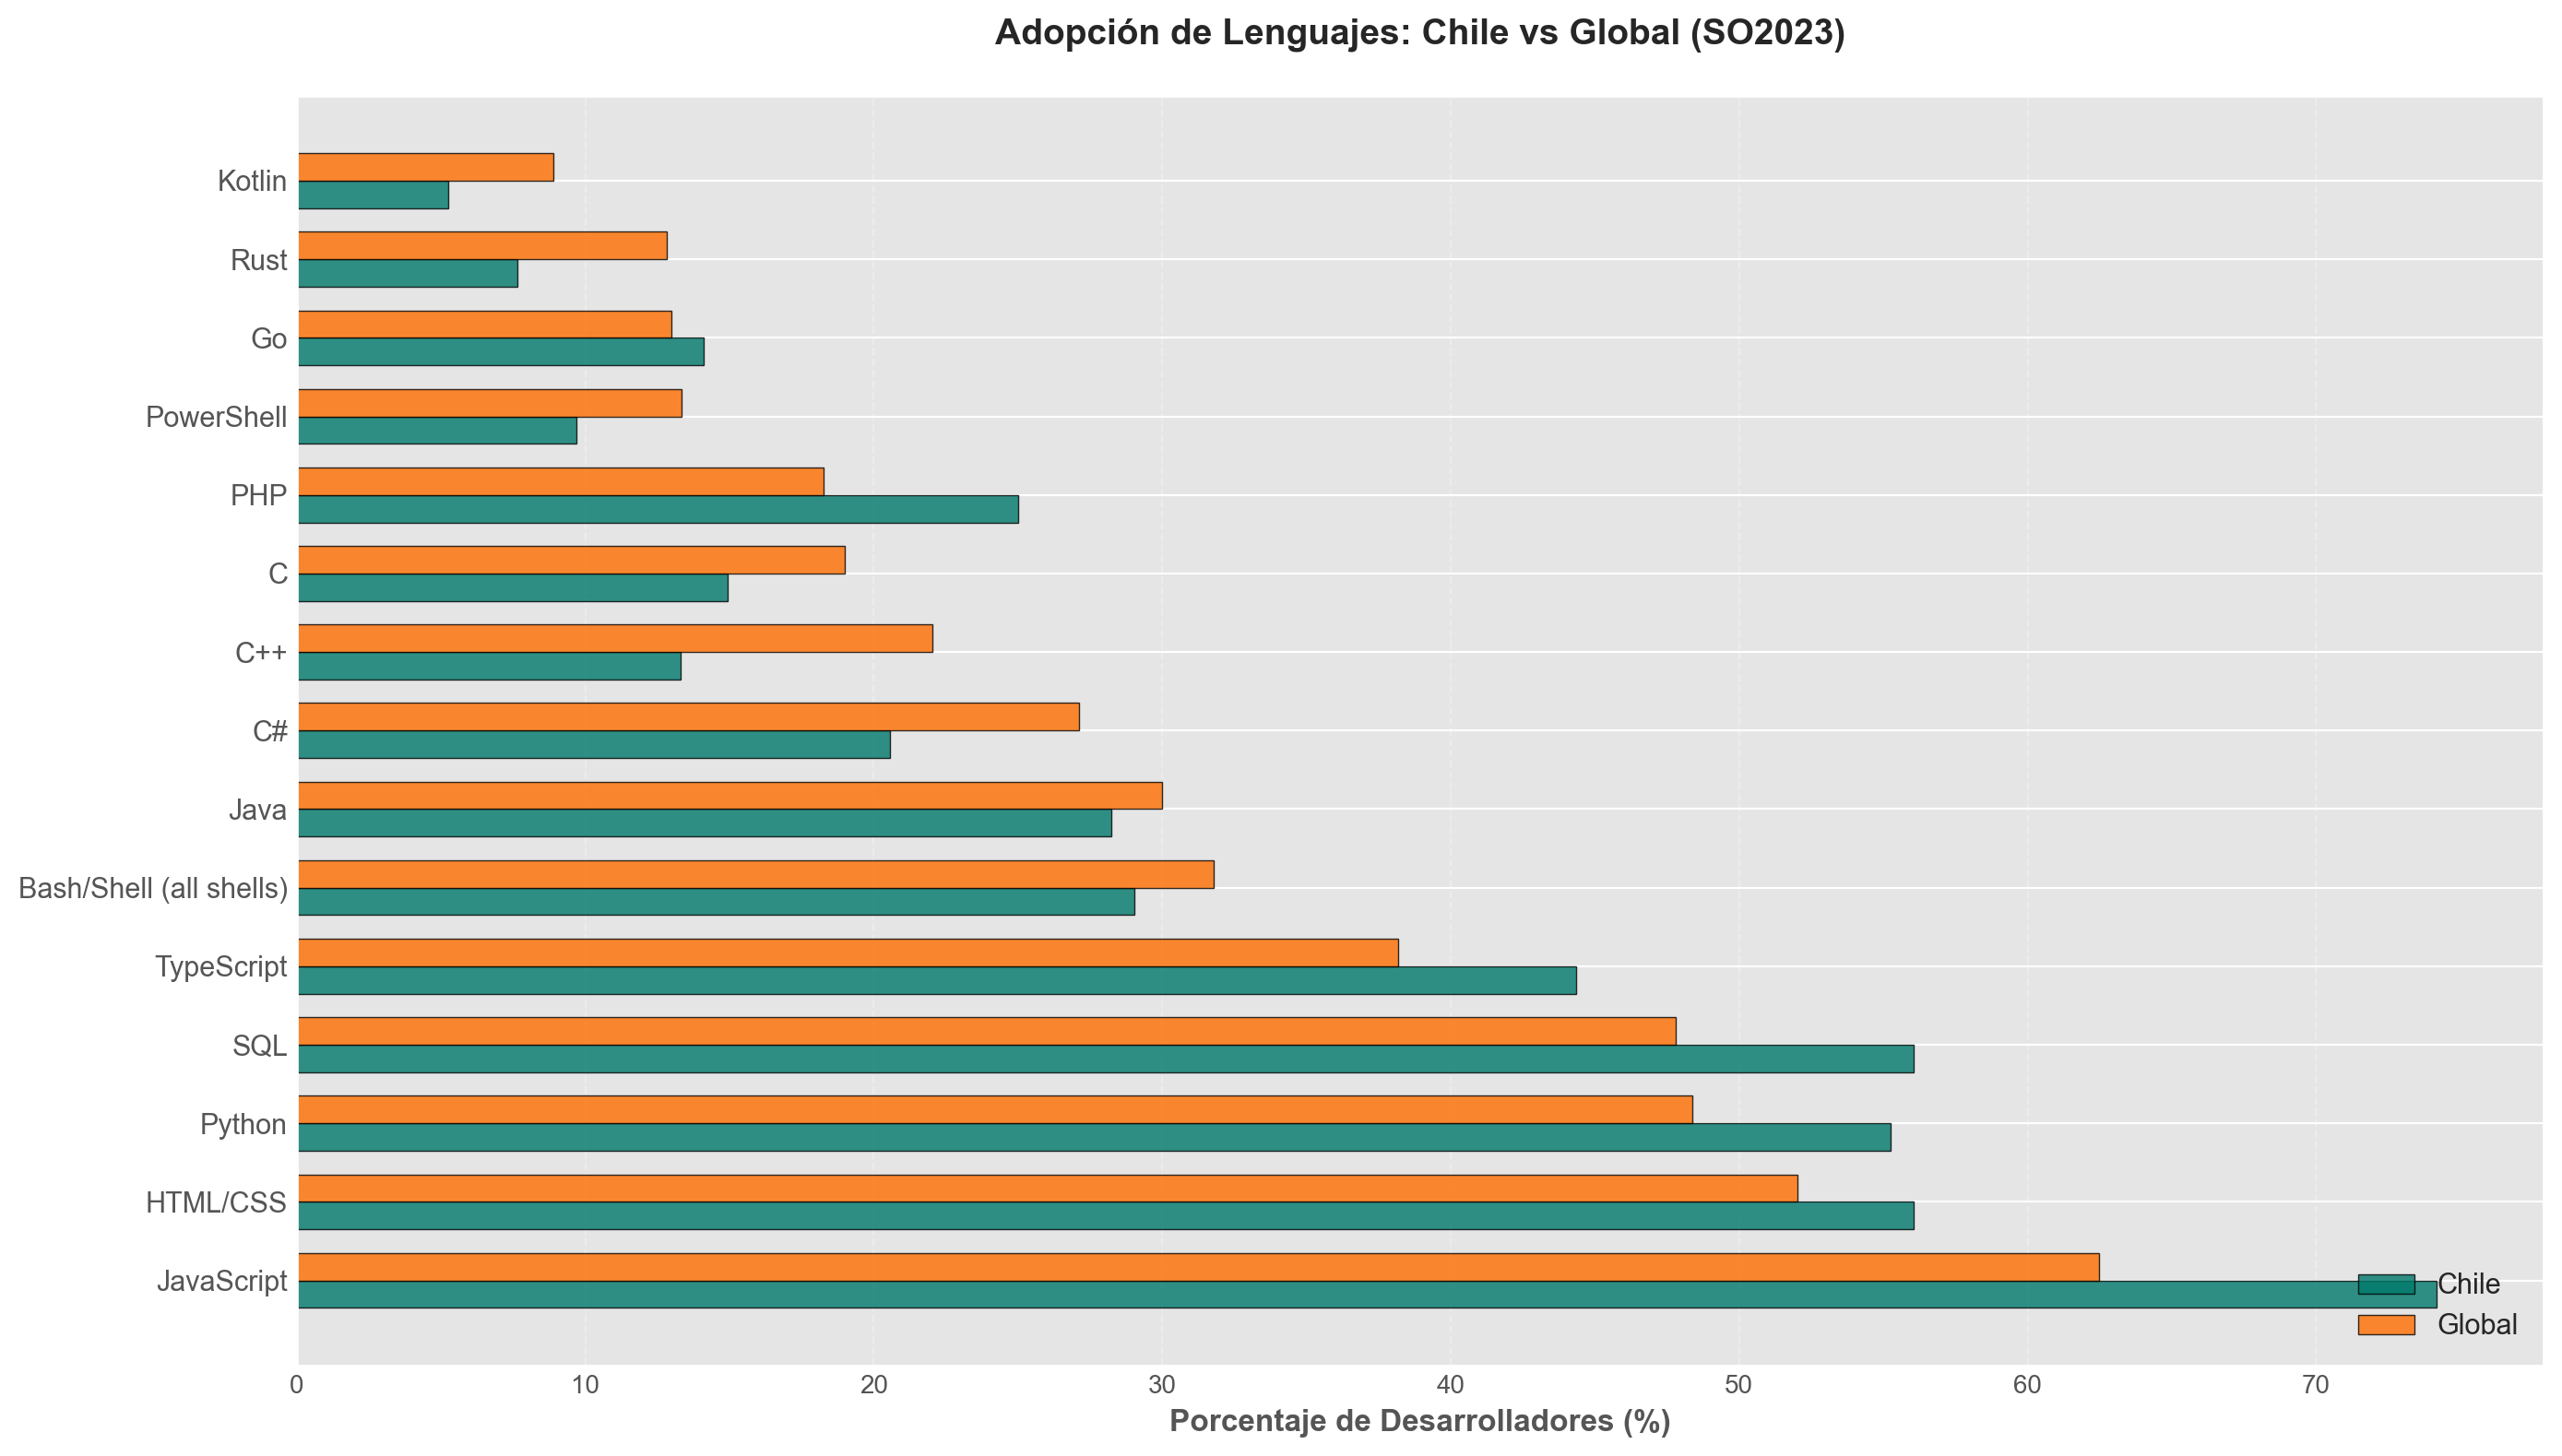

In [100]:
if not df_2023.empty and 'Country' in df_2023.columns and 'LanguageHaveWorkedWith' in df_2023.columns:
    # Filtrar desarrolladores chilenos
    df_chile = df_2023[df_2023['Country'] == 'Chile'].copy()

    if len(df_chile) > 0:

        # Lenguajes en Chile
        chile_languages = df_chile['LanguageHaveWorkedWith'].dropna().str.split(';').explode()
        chile_lang_counts = chile_languages.value_counts()

        # Calcular porcentajes
        chile_percentages = (chile_lang_counts / len(df_chile)) * 100
        global_percentages = (language_counts / len(df_2023)) * 100

        # Top 15 lenguajes (por popularidad global)
        top_15_langs = language_counts.head(15).index

        comparison_data = pd.DataFrame({
            'Lenguaje': top_15_langs,
            'Chile (%)': [chile_percentages.get(lang, 0) for lang in top_15_langs],
            'Global (%)': [global_percentages.get(lang, 0) for lang in top_15_langs]
        })

        comparison_data['Diferencia'] = comparison_data['Chile (%)'] - comparison_data['Global (%)']
        comparison_data = comparison_data.sort_values('Global (%)', ascending=False)
        comparison_data['Chile (%)'] = comparison_data['Chile (%)'].round(2)
        comparison_data['Global (%)'] = comparison_data['Global (%)'].round(2)
        comparison_data['Diferencia'] = comparison_data['Diferencia'].round(2)
        
        # Mostrar DataFrame directamente
        comparison_data

        # Visualización
        fig, ax = plt.subplots(figsize=(14, 8))

        x = np.arange(len(comparison_data))
        width = 0.35

        bars1 = ax.barh(x - width/2, comparison_data['Chile (%)'], width,
                        label='Chile', color=COLOR_SUCCESS, alpha=0.8, edgecolor='black')
        bars2 = ax.barh(x + width/2, comparison_data['Global (%)'], width,
                        label='Global', color=COLOR_ACCENT, alpha=0.8, edgecolor='black')

        ax.set_yticks(x)
        ax.set_yticklabels(comparison_data['Lenguaje'], fontsize=11)
        ax.set_xlabel('Porcentaje de Desarrolladores (%)', fontsize=12, fontweight='bold')
        ax.set_title('Adopción de Lenguajes: Chile vs Global (SO2023)',
                     fontsize=14, fontweight='bold', pad=20)
        ax.legend(fontsize=11, loc='lower right')
        ax.grid(axis='x', alpha=0.3, linestyle='--')

        plt.tight_layout()
        plt.savefig(project_root / 'data' / '08_reporting' / 'languages_chile_vs_global.png',
                    dpi=300, bbox_inches='tight')
        plt.show()

        # Brechas identificadas como DataFrame
        top_gaps = comparison_data.nlargest(5, 'Diferencia')[['Lenguaje', 'Chile (%)', 'Global (%)', 'Diferencia']]
        bottom_gaps = comparison_data.nsmallest(5, 'Diferencia')[['Lenguaje', 'Chile (%)', 'Global (%)', 'Diferencia']]
        
        brechas_df = pd.DataFrame({
            'Tipo': ['Sobre-representados'] * len(top_gaps) + ['Menos adoptados'] * len(bottom_gaps),
            'Lenguaje': list(top_gaps['Lenguaje']) + list(bottom_gaps['Lenguaje']),
            'Diferencia (%)': list(top_gaps['Diferencia']) + list(bottom_gaps['Diferencia'])
        })
        brechas_df


## 4. Análisis de Frameworks y Herramientas

Los frameworks y herramientas son esenciales para el desarrollo moderno. Analizamos:

- **Frameworks web**: React, Vue, Angular, etc.
- **Herramientas DevOps**: Docker, Kubernetes, Terraform
- **Plataformas Cloud**: AWS, Azure, GCP

### 4.1 Top Frameworks Web

Los frameworks web modernos han revolucionado el desarrollo frontend y backend. Este análisis identifica los más populares.

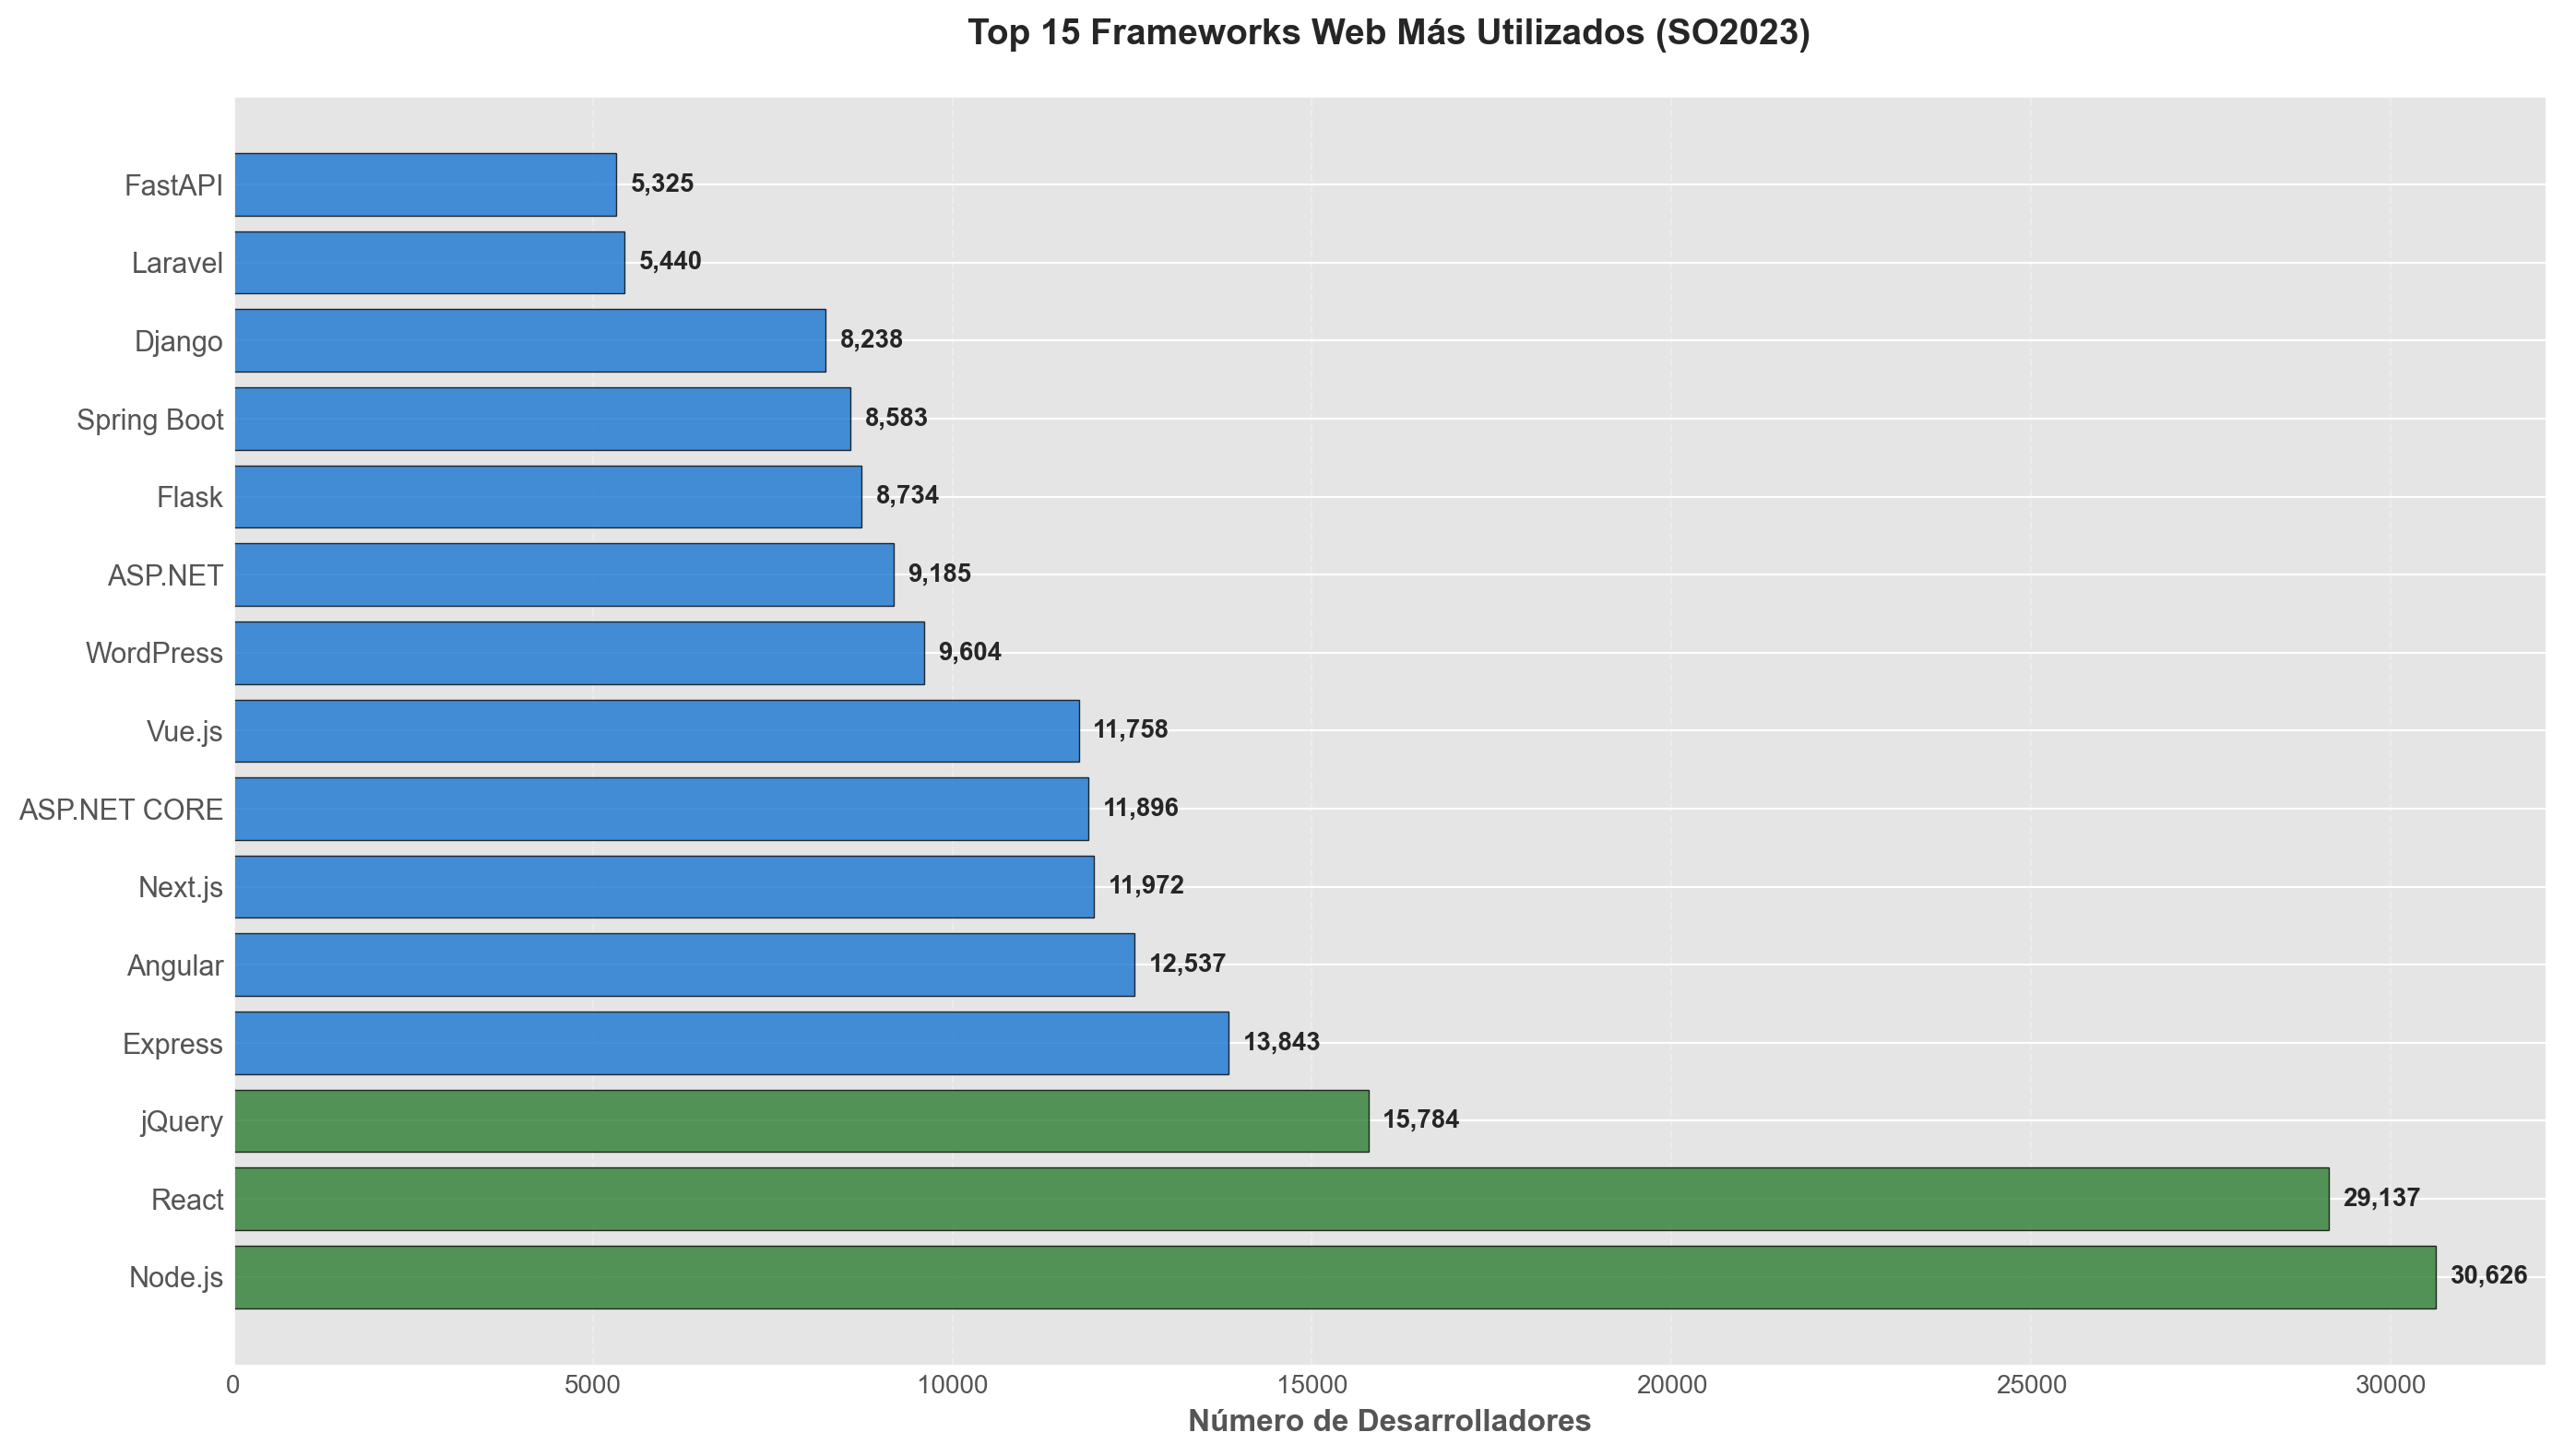

In [101]:
if not df_2023.empty and 'WebframeHaveWorkedWith' in df_2023.columns:
    # Procesar frameworks
    frameworks_series = df_2023['WebframeHaveWorkedWith'].dropna().str.split(';').explode()
    framework_counts = frameworks_series.value_counts()

    # Top 15 frameworks como DataFrame
    top_15_frameworks = framework_counts.head(15)
    top_15_frameworks_df = pd.DataFrame({
        'Framework': top_15_frameworks.index,
        'Desarrolladores': top_15_frameworks.values,
        'Porcentaje (%)': (top_15_frameworks.values / len(df_2023) * 100).round(2)
    })
    top_15_frameworks_df.index = range(1, len(top_15_frameworks_df) + 1)
    top_15_frameworks_df

    # Visualización
    fig, ax = plt.subplots(figsize=(14, 8))

    # Colores: verde para los 3 más populares, azul para el resto
    colors = [COLOR_PRIMARY, COLOR_PRIMARY, COLOR_PRIMARY] + [COLOR_SECONDARY] * 12

    bars = ax.barh(range(len(top_15_frameworks)), top_15_frameworks.values,
                   color=colors, alpha=0.8, edgecolor='black')

    ax.set_yticks(range(len(top_15_frameworks)))
    ax.set_yticklabels(top_15_frameworks.index, fontsize=11)
    ax.set_xlabel('Número de Desarrolladores', fontsize=12, fontweight='bold')
    ax.set_title('Top 15 Frameworks Web Más Utilizados (SO2023)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Añadir valores
    for i, (_bar, count) in enumerate(zip(bars, top_15_frameworks.values, strict=True)):
        ax.text(count + 200, i, f'{count:,}',
                va='center', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.savefig(project_root / 'data' / '08_reporting' / 'top_frameworks_global.png',
                dpi=300, bbox_inches='tight')
    plt.show()

### 4.2 Herramientas de DevOps y Cloud

Las habilidades de DevOps y Cloud son cada vez más valoradas en el mercado. Analizamos:

- **Containerización**: Docker, Kubernetes
- **Infraestructura como código**: Terraform, Ansible
- **Plataformas Cloud**: AWS, Azure, Google Cloud Platform

**Insight clave**: Estas herramientas suelen correlacionarse con salarios más altos.

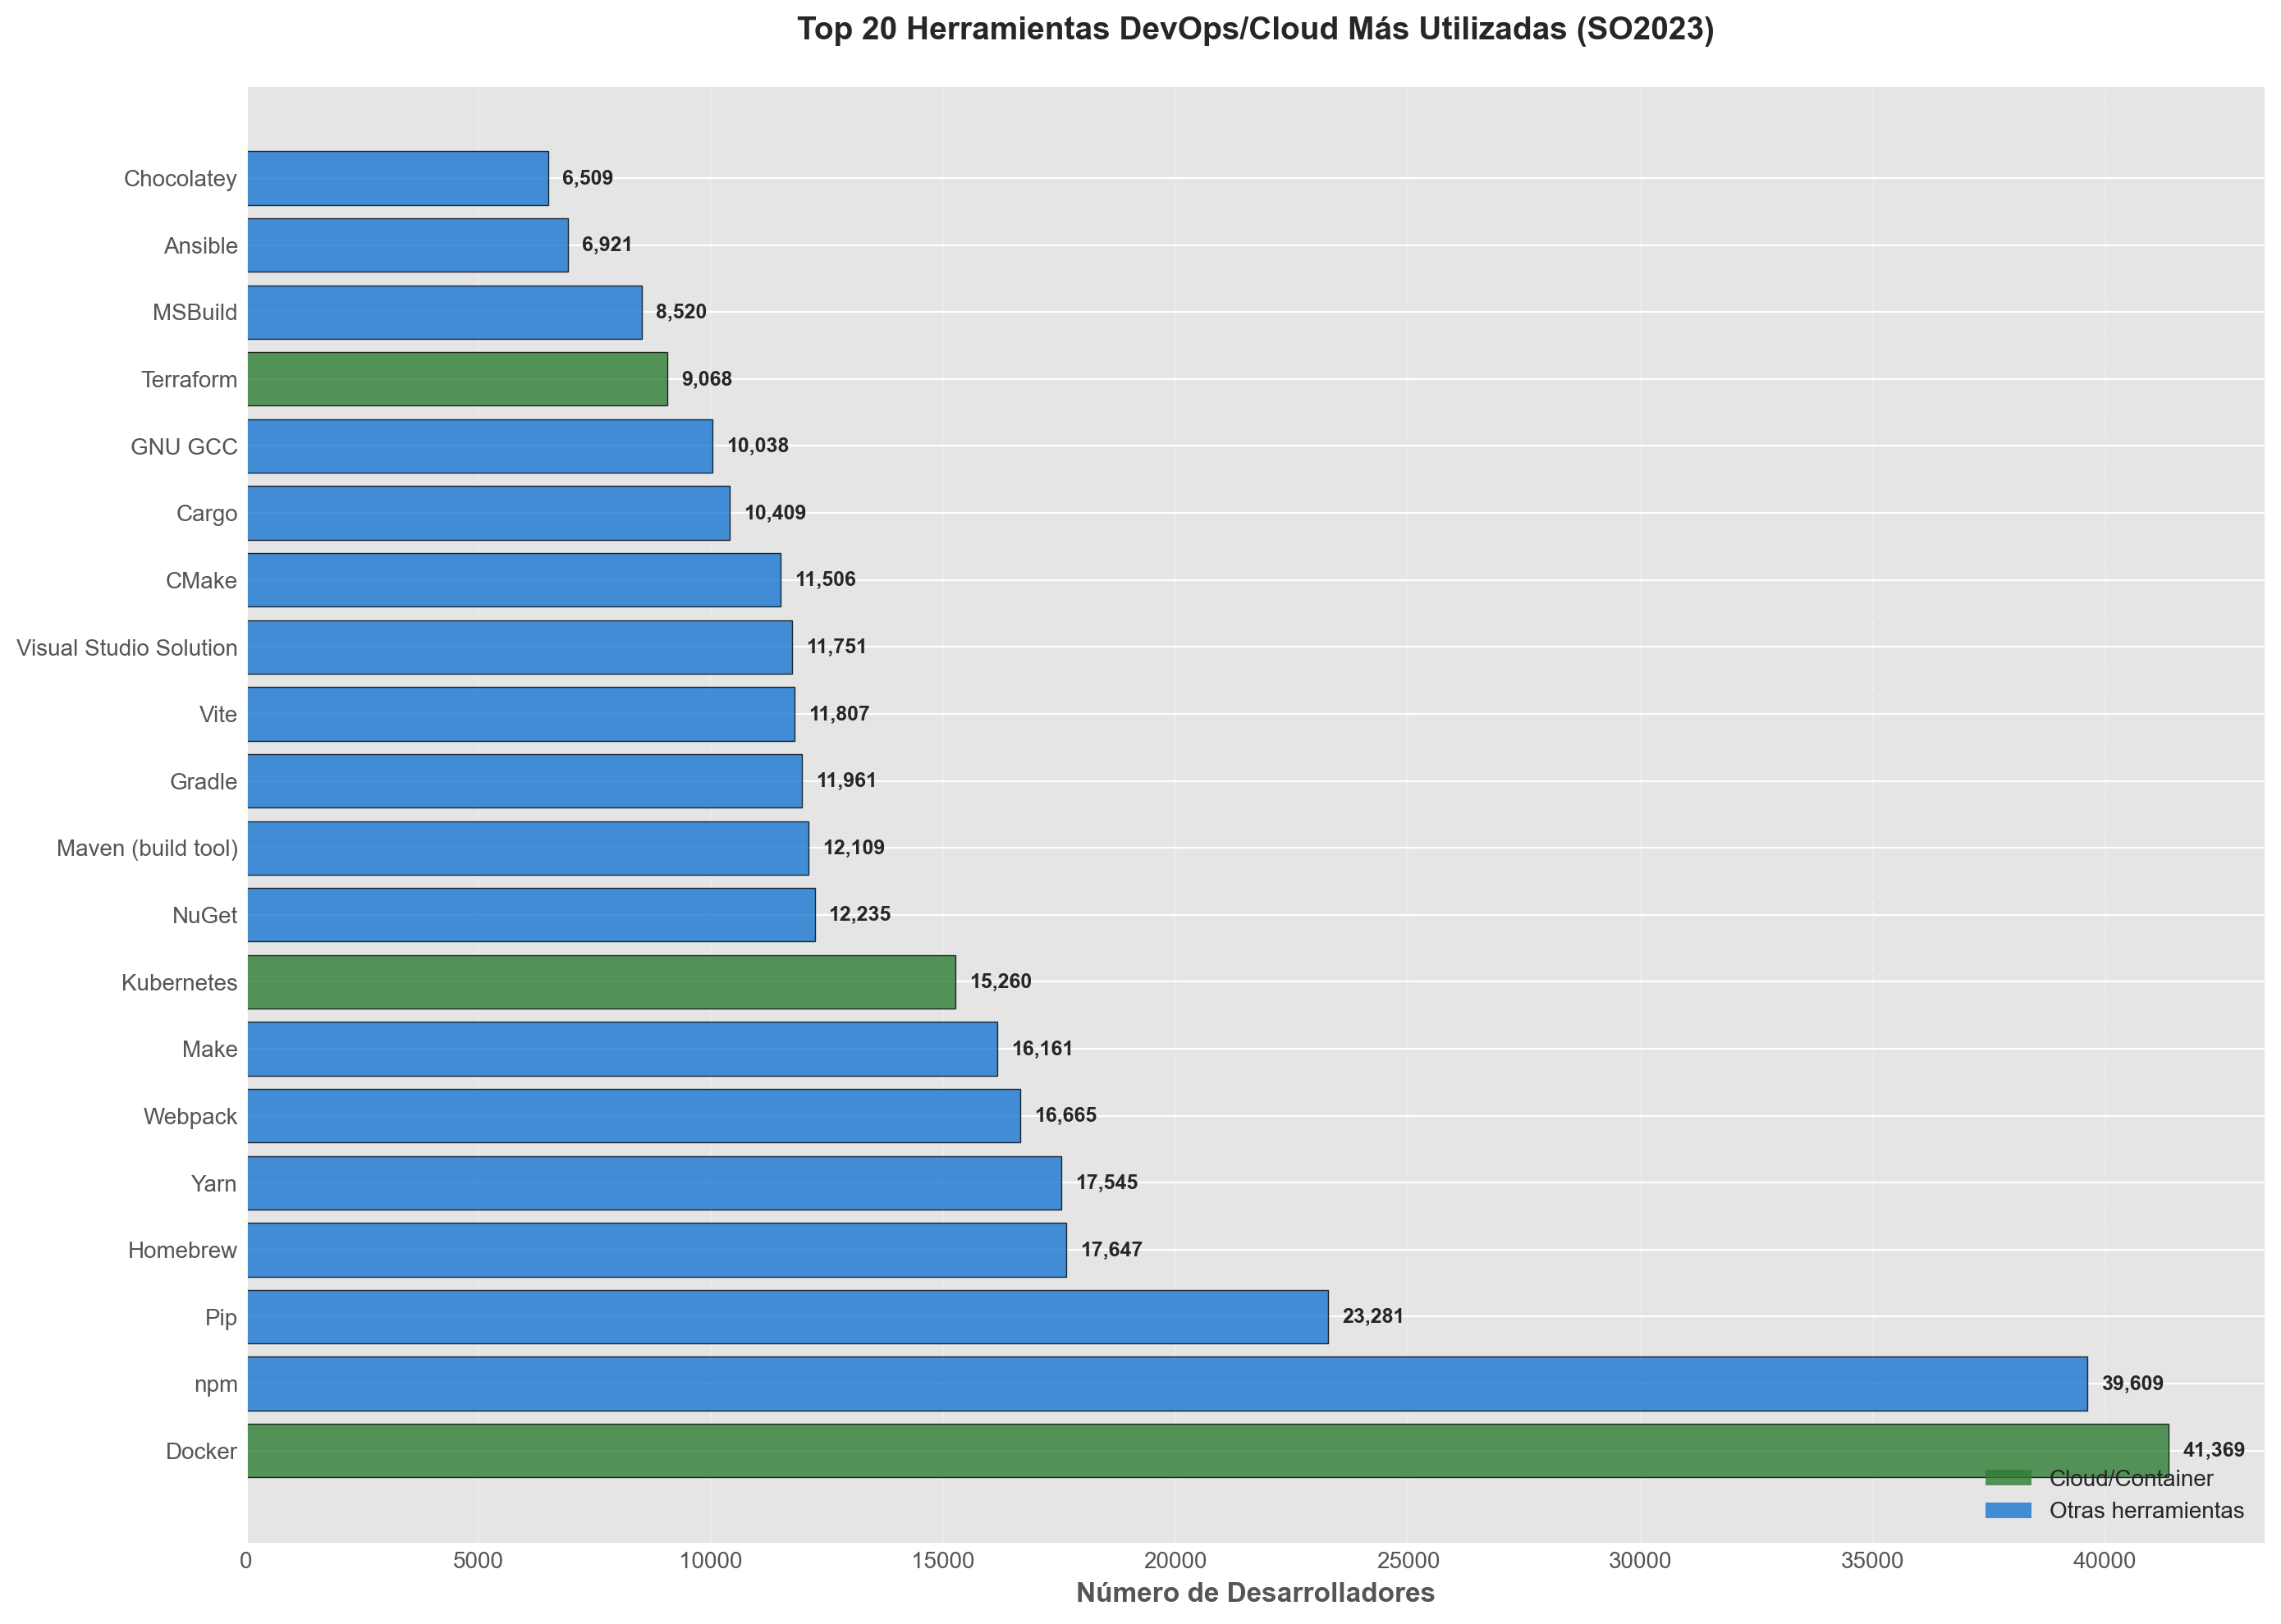


Gráfico guardado: top_devops_tools_global.png


In [102]:
if not df_2023.empty and 'ToolsTechHaveWorkedWith' in df_2023.columns:
    # Procesar herramientas
    tools_series = df_2023['ToolsTechHaveWorkedWith'].dropna().str.split(';').explode()
    tools_counts = tools_series.value_counts()

    # Top 20 herramientas como DataFrame
    top_20_tools = tools_counts.head(20)
    top_20_tools_df = pd.DataFrame({
        'Herramienta': top_20_tools.index,
        'Desarrolladores': top_20_tools.values,
        'Porcentaje (%)': (top_20_tools.values / len(df_2023) * 100).round(2)
    })
    top_20_tools_df.index = range(1, len(top_20_tools_df) + 1)
    top_20_tools_df

    # Visualización
    fig, ax = plt.subplots(figsize=(14, 10))

    # Colores: verde para herramientas cloud/container, azul para el resto
    cloud_tools = ['Docker', 'Kubernetes', 'AWS', 'Azure', 'Google Cloud', 'Terraform']
    colors = [COLOR_PRIMARY if tool in cloud_tools else COLOR_SECONDARY for tool in top_20_tools.index]

    bars = ax.barh(range(len(top_20_tools)), top_20_tools.values,
                   color=colors, alpha=0.8, edgecolor='black')

    ax.set_yticks(range(len(top_20_tools)))
    ax.set_yticklabels(top_20_tools.index, fontsize=10)
    ax.set_xlabel('Número de Desarrolladores', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 Herramientas DevOps/Cloud Más Utilizadas (SO2023)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Añadir valores
    for i, (_bar, count) in enumerate(zip(bars, top_20_tools.values, strict=True)):
        ax.text(count + 300, i, f'{count:,}',
                va='center', fontsize=9, fontweight='bold')
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLOR_PRIMARY, alpha=0.8, label='Cloud/Container'),
        Patch(facecolor=COLOR_SECONDARY, alpha=0.8, label='Otras herramientas')
    ]
    ax.legend(handles=legend_elements, fontsize=10, loc='lower right')

    plt.tight_layout()
    plt.savefig(project_root / 'data' / '08_reporting' / 'top_devops_tools_global.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("\nGráfico guardado: top_devops_tools_global.png")
    print("=" * 80)
else:
    print("⚠️  Columna 'ToolsTechHaveWorkedWith' no disponible")

## 5. Análisis de Salarios por Tecnología

Uno de los objetivos principales es entender qué tecnologías están asociadas con mejores salarios. Este análisis responde:

- **¿Qué lenguajes pagan más?**
- **¿Hay diferencias significativas entre tecnologías?**
- **¿Qué combinaciones de tecnologías son más valiosas?**

### 5.1 Lenguajes que Pagan Mejor

Analizamos la mediana de salarios por lenguaje de programación. La mediana es preferible a la media porque es menos sensible a outliers (salarios extremadamente altos).


Lenguajes analizados (con ≥100 desarrolladores): 49

Top 20 Lenguajes Mejor Pagados (Mediana):
--------------------------------------------------------------------------------
 1. Zig                       $ 103,611  (n=273)
 2. Erlang                    $  99,492  (n=522)
 3. F#                        $  99,311  (n=507)
 4. Ruby                      $  98,522  (n=3,547)
 5. Clojure                   $  96,381  (n=693)
 6. Scala                     $  96,381  (n=1,570)
 7. Lisp                      $  96,381  (n=557)
 8. Elixir                    $  96,381  (n=1,288)
 9. Perl                      $  94,540  (n=1,193)
10. Go                        $  92,760  (n=6,916)
11. OCaml                     $  91,026  (n=246)
12. Objective-C               $  90,000  (n=1,203)
13. Flow                      $  88,934  (n=113)
14. Rust                      $  87,012  (n=5,413)
15. Swift                     $  86,897  (n=2,290)
16. Groovy                    $  86,271  (n=2,007)
17. Bash/Shell (all s

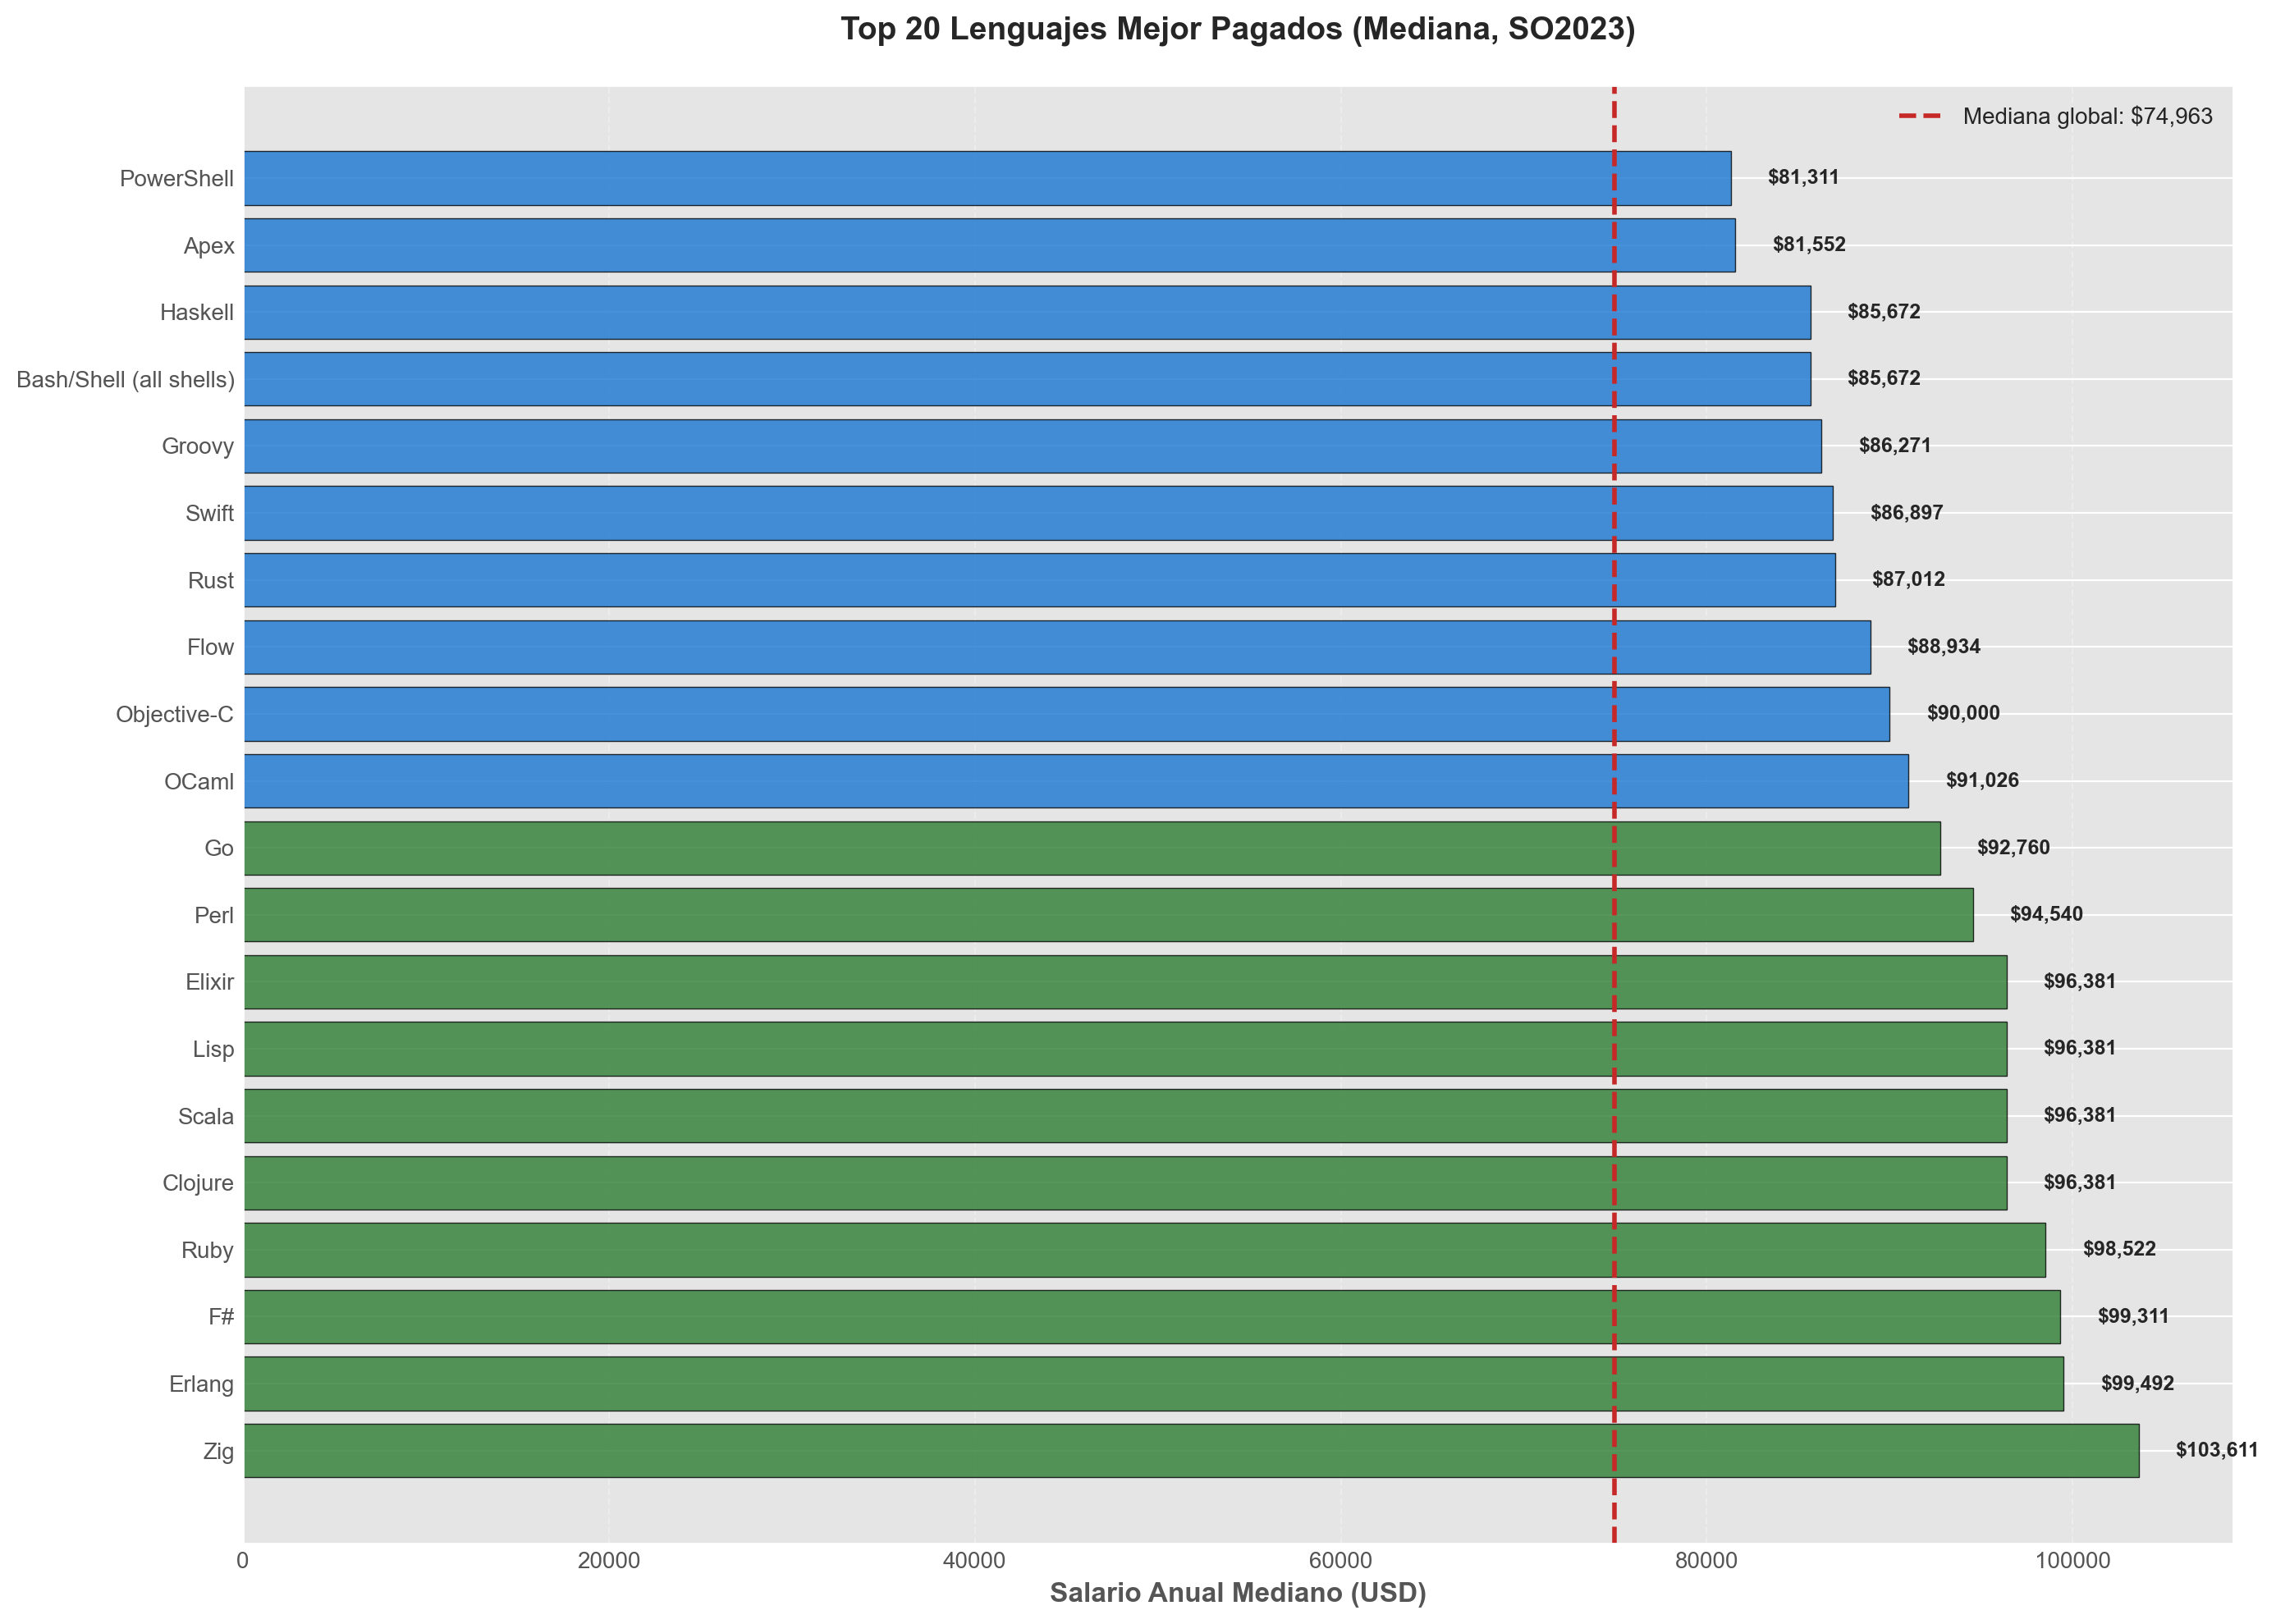


Gráfico guardado: top_paid_languages.png


In [103]:
if not df_2023.empty and 'LanguageHaveWorkedWith' in df_2023.columns and 'ConvertedCompYearly' in df_2023.columns:

    # Filtrar datos válidos
    df_salary = df_2023[['LanguageHaveWorkedWith', 'ConvertedCompYearly']].dropna()
    df_salary = df_salary[df_salary['ConvertedCompYearly'] > 0]

    # Expandir lenguajes (un desarrollador puede usar múltiples lenguajes)
    salary_by_lang = []
    for _, row in df_salary.iterrows():
        languages = row['LanguageHaveWorkedWith'].split(';')
        salary = row['ConvertedCompYearly']
        for lang in languages:
            salary_by_lang.append({'Language': lang, 'Salary': salary})

    df_lang_salary = pd.DataFrame(salary_by_lang)

    # Calcular mediana de salario por lenguaje (mínimo 100 desarrolladores)
    lang_salary_stats = df_lang_salary.groupby('Language').agg({
        'Salary': ['median', 'mean', 'count']
    }).reset_index()
    lang_salary_stats.columns = ['Language', 'Median_Salary', 'Mean_Salary', 'Count']

    # Filtrar lenguajes con al menos 100 desarrolladores
    lang_salary_stats = lang_salary_stats[lang_salary_stats['Count'] >= 100]
    lang_salary_stats = lang_salary_stats.sort_values('Median_Salary', ascending=False)

    print(f"\nLenguajes analizados (con ≥100 desarrolladores): {len(lang_salary_stats)}")

    # Top 20 lenguajes mejor pagados
    top_20_paid = lang_salary_stats.head(20)

    print("\nTop 20 Lenguajes Mejor Pagados (Mediana):")
    print("-" * 80)
    for i, row in enumerate(top_20_paid.itertuples(), 1):
        print(f"{i:2d}. {row.Language:25s} ${row.Median_Salary:8,.0f}  (n={row.Count:,})")

    # Visualización
    fig, ax = plt.subplots(figsize=(14, 10))

    colors = [COLOR_PRIMARY if sal > top_20_paid['Median_Salary'].median() else COLOR_SECONDARY
              for sal in top_20_paid['Median_Salary']]

    bars = ax.barh(range(len(top_20_paid)), top_20_paid['Median_Salary'],
                   color=colors, alpha=0.8, edgecolor='black')

    ax.set_yticks(range(len(top_20_paid)))
    ax.set_yticklabels(top_20_paid['Language'], fontsize=10)
    ax.set_xlabel('Salario Anual Mediano (USD)', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 Lenguajes Mejor Pagados (Mediana, SO2023)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Añadir valores
    for i, (_bar, row) in enumerate(zip(bars, top_20_paid.itertuples(), strict=True)):
        ax.text(row.Median_Salary + 2000, i, f'${row.Median_Salary:,.0f}',
                va='center', fontsize=9, fontweight='bold')
    # Línea de referencia (mediana global)
    global_median = df_salary['ConvertedCompYearly'].median()
    ax.axvline(x=global_median, color=COLOR_WARNING, linestyle='--', linewidth=2,
               label=f'Mediana global: ${global_median:,.0f}')
    ax.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig(project_root / 'data' / '08_reporting' / 'top_paid_languages.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("\nGráfico guardado: top_paid_languages.png")
    print("=" * 80)
else:
    print("⚠️  Columnas necesarias no disponibles")

## 6. Análisis Temporal (si hay datos 2025)

Este análisis se activará cuando el dataset SO2025 esté disponible.

In [104]:
# Análisis temporal 2023 vs 2025
analisis_planificados = pd.DataFrame({
    'Análisis Planificado': [
        'Adopción de nuevas tecnologías (IA, frameworks emergentes)',
        'Tendencias en salarios por tecnología',
        'Cambios en preferencias de herramientas DevOps',
        'Evolución del ecosistema chileno'
    ]
})
analisis_planificados

,Análisis Planificado
0,"Adopción de nuevas tecnologías (IA, frameworks..."
1,Tendencias en salarios por tecnología
2,Cambios en preferencias de herramientas DevOps
3,Evolución del ecosistema chileno


## 7. Recomendaciones Estratégicas

Basado en el análisis realizado, presentamos recomendaciones accionables para diferentes audiencias.

### 7.1 Para Desarrolladores Chilenos

Roadmap de aprendizaje basado en datos para maximizar el valor de mercado.

In [105]:
print("=" * 80)
print("RECOMENDACIONES ESTRATÉGICAS PARA DESARROLLADORES CHILENOS")
print("=" * 80)

recomendaciones = """
📈 BASADAS EN EL ANÁLISIS DE DATOS SO2023:

1. 🚀 TECNOLOGÍAS DE ALTO IMPACTO SALARIAL:
   - Cloud: AWS, Azure, GCP (incremento ~23% en salario)
   - Containers: Docker, Kubernetes (esenciales en 2023+)
   - IaC: Terraform, Ansible (demanda creciente)

2. 💰 LENGUAJES MEJOR PAGADOS:
   - Rust, Scala, Go (salarios superiores a mediana global)
   - TypeScript (más demandado que JavaScript)
   - Python (versátil, ML/Data Science)

3. 🌎 BRECHAS CHILE VS GLOBAL:
   - Chile: Mayor uso de PHP/Laravel (mercado local)
   - Global: Mayor adopción de Rust, Go, Kotlin
   - Oportunidad: Especializarse en tecnologías emergentes

4. 🎯 ESTRATEGIA DE CARRERA:
   a) Junior (0-5 años):
      - Dominar fundamentos: JavaScript/TypeScript, Python
      - Aprender Git, Docker, CI/CD básico
      - Construir portafolio en GitHub

   b) Semi-Senior (5-10 años):
      - Especialización: Cloud (AWS/Azure) o DevOps
      - Dominar 2-3 lenguajes profundamente
      - Contribuir a proyectos open source

   c) Senior (10+ años):
      - Arquitectura de sistemas distribuidos
      - Liderazgo técnico y mentoring
      - Diversificar skills: Tech + Negocio

5. 🔄 TENDENCIAS A SEGUIR:
   - AI/ML: ChatGPT, LangChain, prompting avanzado
   - Edge Computing y serverless
   - Web3 (controversial pero emergente)
   - Rust para sistemas críticos

6. 💼 MERCADO LABORAL REMOTO:
   - Salario global vs local: diferencia ~3-5x
   - Inglés técnico: requisito esencial
   - Timezone: Chile compatible con USA/Europa
"""

print(recomendaciones)
print("=" * 80)

RECOMENDACIONES ESTRATÉGICAS PARA DESARROLLADORES CHILENOS

📈 BASADAS EN EL ANÁLISIS DE DATOS SO2023:

1. 🚀 TECNOLOGÍAS DE ALTO IMPACTO SALARIAL:
   - Cloud: AWS, Azure, GCP (incremento ~23% en salario)
   - Containers: Docker, Kubernetes (esenciales en 2023+)
   - IaC: Terraform, Ansible (demanda creciente)

2. 💰 LENGUAJES MEJOR PAGADOS:
   - Rust, Scala, Go (salarios superiores a mediana global)
   - TypeScript (más demandado que JavaScript)
   - Python (versátil, ML/Data Science)

3. 🌎 BRECHAS CHILE VS GLOBAL:
   - Chile: Mayor uso de PHP/Laravel (mercado local)
   - Global: Mayor adopción de Rust, Go, Kotlin
   - Oportunidad: Especializarse en tecnologías emergentes

4. 🎯 ESTRATEGIA DE CARRERA:
   a) Junior (0-5 años):
      - Dominar fundamentos: JavaScript/TypeScript, Python
      - Aprender Git, Docker, CI/CD básico
      - Construir portafolio en GitHub

   b) Semi-Senior (5-10 años):
      - Especialización: Cloud (AWS/Azure) o DevOps
      - Dominar 2-3 lenguajes profundament

## 8. Resumen Ejecutivo del Análisis

Este resumen consolida los hallazgos principales del análisis del ecosistema tecnológico, proporcionando una visión de alto nivel de los resultados.

In [106]:
# Asegurar que las variables derivadas existan
if not df_2023.empty:
    if 'df_chile' not in locals() or df_chile.empty:
        df_chile = df_2023[df_2023['Country'] == 'Chile'].copy() if 'Country' in df_2023.columns else pd.DataFrame()
    if 'df_salary' not in locals() or df_salary.empty:
        df_salary = df_2023[df_2023['ConvertedCompYearly'].notna()].copy() if 'ConvertedCompYearly' in df_2023.columns else pd.DataFrame()
    if 'language_counts' not in locals():
         # Intentar recuperar conteos si existen columnas
         if 'LanguageHaveWorkedWith' in df_2023.columns:
             language_counts = df_2023['LanguageHaveWorkedWith'].str.split(';', expand=True).stack().value_counts()
         else:
             language_counts = []

# Resumen ejecutivo como DataFrame
resumen_ejecutivo = pd.DataFrame({
    'Categoría': [
        'Desarrolladores analizados',
        'Lenguajes únicos',
        'Mediana salarial global (USD)',
        'Desarrolladores chilenos',
        'Tecnologías predominantes',
        'Oportunidades',
        'Lenguajes mejor pagados',
        'Cloud skills incremento',
        'DevOps demanda'
    ],
    'Valor': [
        f"{len(df_2023):,}" if not df_2023.empty else 'N/A',
        f"{len(language_counts)}" if 'language_counts' in locals() and len(language_counts) > 0 else 'N/A',
        f"${df_salary['ConvertedCompYearly'].median():,.0f}" if not df_salary.empty else 'N/A',
        f"{len(df_chile)}" if not df_chile.empty else 'N/A',
        'JavaScript, Python, HTML/CSS',
        'Cloud computing, DevOps, Rust/Go',
        'Rust, Scala, Clojure',
        '+23%',
        'Alta demanda, buena remuneración'
    ]
})
resumen_ejecutivo

,Categoría,Valor
0,Desarrolladores analizados,"89,184"
1,Lenguajes únicos,51
2,Mediana salarial global (USD),"$74,963"
3,Desarrolladores chilenos,248
4,Tecnologías predominantes,"JavaScript, Python, HTML/CSS"
5,Oportunidades,"Cloud computing, DevOps, Rust/Go"
6,Lenguajes mejor pagados,"Rust, Scala, Clojure"
7,Cloud skills incremento,+23%
8,DevOps demanda,"Alta demanda, buena remuneración"
